In [872]:
%reload_ext autoreload
%autoreload 2
#exec
#try:    importlib.reload(Jupytils)
#except: import Jupytils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
plt.style.use('seaborn-darkgrid')
#warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 8)
np.set_printoptions(precision=10)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
plt.rcParams['figure.figsize'] = (14.0, 5.0)

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr, chisquare, chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score 
from sklearn.metrics import balanced_accuracy_score, r2_score
from sklearn.metrics import average_precision_score, roc_auc_score

import io;
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import warnings

warnings.filterwarnings("ignore")

In [873]:
#%%writefile nommodel.py
#!/usr/local/bin/python 
import sys, os, datetime, getopt, math, re, gc, json, collections
import pandas as pd
import numpy as np
from   collections import defaultdict
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr, chisquare, chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score 
from sklearn.metrics import balanced_accuracy_score, r2_score

#*** NOTE: DO NOT EDIT THIS FILE - THIS iS CREATED FROM: ifx_loadscores.ipynb
def findCatCon(df1, binc=2, conc=100):
    uns = df1[df1.columns[1:]].nunique()
    bins = list(uns[uns == binc].index)
    cons = list(uns[uns >= conc].index)

    return bins, cons

def genPairs(b='a b c'.split(), e='1 2 3'.split()):
    for i,ii in enumerate(b):
        for j,jj in enumerate(e):
            yield(ii, jj, i, j)

#-- Display Visualize tree
def displayDT(dt, fn=None, cn=None):
    dd = io.StringIO()
    export_graphviz(dt, out_file=dd, filled=True, feature_names=fn, class_names=cn, rounded=True)
    graph = pydotplus.graph_from_dot_data(dd.getvalue())  
    display(Image(graph.create_png()))

# This has a bug when it prints fname - fix it later
def dtreePars(tree, fname, log=True):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value     = tree.tree_.value
    impurity  = tree.tree_.impurity
    nodeCount = tree.tree_.node_count
    giniSum   = 0;

    def recurse1(node, depth, acc, log=True):
        ns = tree.tree_.n_node_samples[node]
        if (threshold[node] != -2):
            if (log): print(f"{log} {fname} <= {threshold[node]}")
            acc.append(threshold[node])
            if left[node] != -1:
                ret = recurse1 ( left[node], depth+1, acc, log)
            if right[node] != -1:
                ret = recurse1 (right[node], depth+1, acc, log)
        else:  # leaf
            target = value[node][0]
            v = target[0] if len(target)==1 else np.argmax(value[node])
            if(log): print(f"Leaf: {v}")
            ret = None
            
        return ret
    acc = []
    ret = recurse1(0, 0, acc, log)
    return nodeCount, acc, sum(impurity), threshold

# Simple check two different combinations to get an idea
def plotOnOff(df1, cat1, con1, plot= True, bands=(0,0), *args):
    cats   = df1[cat1][1:]
    cons   = df1[con1]
    cond   = cons.values[1:] - cons.values[0:-1]
    slopes = np.array([ 1 if c >= 0 else -1 for c in cond])
    
    vc=df1[cat1].value_counts()
    minmax={}
    for v in vc.index:
        ldf = df1[df1[cat1] == v][con1]
        minmax[v] = (min(ldf), max(ldf))

    if (plot):
        fig, ax1 = plt.subplots()
        ax1.plot(cons[1:], color="r", label=con1 + " :continuous")
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.plot(cats, drawstyle="steps", color="b", label= cat1 + " : cats")

        #ones = df1.index[df1[cat1] == 1]
        #pons= [slopes[c-df1.index[0]] for c in ones]
        #ax2.plot(ones, pons, marker='x', drawstyle="steps", color="g", label= "slopes")
        #ax2.plot(df1.index[1:], slopes, marker='x', drawstyle="steps", color="g", label= "slopes")
        ax2.scatter(df1.index[1:], slopes, marker='x', color="g", label= "slopes")

        if ( bands[0] != bands[1]):
            y1,y2 = ax2.get_ylim()
            x= range(bands[0], bands[1] )
            ax2.fill_between(x, y1, y2, alpha=0.2, facecolor='g',antialiased=True)


        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.legend()
        plt.show()
    
    # return similarity measures
    a = cats[cats==1].values.reshape(1,-1)
    b = slopes[cats==1].reshape(1,-1)
    cos = cosine_similarity( a, b)[0][0]
    jsim= sklearn.metrics.jaccard_score(a[0], b[0], labels=None, average='binary')

    # check if ON is subset of OFF
    r1 = minmax[0] 
    r2 = minmax[1]

    #overlap score - how much of overlap for ON and OFF periods
    overlap = r2[0] >= r1[0] and r2[1] <= r1[1]
    olScore = 0 if (overlap) else 1
    olScore+= r1[0] - r2[0]  if r2[0] < r1[0] else 0
    olScore+= r2[1] - r1[1]  if r2[1] > r1[1] else 0
    return cos, jsim, olScore, minmax, slopes, cats, cons, cond

test = False
if ( test):
    cat1, con1, _, _= pairs[-1]
    #cos, jsim, isSubset, minmax, cats, cons, cond, slopes = plotOnOff(df1[200:300], *pairs[-1])
    l1, l2 = 200, 300
    cos, jsim, olScore, minmax, slopes, cats, cons, cond = plotOnOff(df1, cat1, con1, True, (l1, l2))
    plotOnOff(df1[l1:l2], cat1, con1, True)
    #plotOnOff(df1, *pairs[-2])
    print(f'cat->con {abs(cos)}, Jacards: {jsim}, overlap: {olScore}, minmax: {minmax}')


In [876]:
# Find attributes for pair
def DTNominal2Continuos(dfn, cat1, con1, plot= True):
    if (plot): print(f"Finding attributes for:  '{cat1}' ==> '{con1}'")
    # 1. get a balanced data set -> resample to make up for larger samples

    X=dfn[cat1].values.reshape(-1,1) # Categorical
    y=dfn[con1].values.reshape(-1,1) # Continuous

    #Catgorical to predict continuous variable
    dtree1 = DecisionTreeRegressor(criterion='mse', max_depth=3)
    dtree1.fit(X=X, y=y)
    
    yh1 = dtree1.predict(X)
    pco, pval = pearsonr(X.reshape(-1,), yh1.reshape((-1,)))

    pcor1, pval1 = pearsonr(y.reshape(-1,), yh1)
    coss1 = cosine_similarity(y.reshape((-1,1)), yh1.reshape((-1,1)))[0][0]
    nnodes1 = dtree1.tree_.node_count
    if ( plot):
        print(f"#nodes: {nnodes1} cor: {pcor1}, {pval1}, CosineSim: {coss1}, ")
        print(f'dtree1.feature_importances_: {dtree1.feature_importances_}')
        displayDT(dtree1)

        plt.plot(yh1.reshape((-1,1)), label="yh1: Predicted")
        plt.plot(y.reshape((-1,1)), label="y: Actual")
        plt.legend()

    ret = {'nominal': cat1, 'continuous': con1, 
           'Cat2Con_nnodes'   : nnodes1,  'Cat2Con_cor'     :  pcor1  ,  'Cat2Con_corp'  : pval1,
           'Cat2Con_cossim'   : coss1
          }
    return ret


In [1201]:
#predict Nominal from continuous 
def DTContinuous2Nominal(dfn, cat1, con1, plot= True, bands=(0,0)):
    cos, jsim, olScore, minmax, slopes, cats, cons, cond = plotOnOff(dfn, cat1, con1, plot, bands)
    
    dfn1 = dfn[1:]

    idxs= dfn1.index> 0
    #rg = minmax[1]
    #idxs= (dfn1[con1]  >= rg[0]) & (dfn1[con1]  <= rg[1])
    #idxs= (dfn1[con1]  >= rg[1])
    #idxs= (dfn1[con1]  <= rg[0])
    yy=dfn1[idxs][cat1].values
    XX=dfn1[idxs][con1].values
    SS=slopes[idxs] # slopes +ve or -ves 
    CO=cond[idxs]   # first order differences
    XX1=np.concatenate((XX.reshape(-1,1),SS.reshape(-1,1)), axis=1)
    XX1=np.concatenate((XX.reshape(-1,1),CO.reshape(-1,1), SS.reshape(-1,1)), axis=1)
    yy1=yy
    
    #len(yy), len(XX), len(SS), len(CO), len(cons), len(idxs), len(dfn)

    #prediction of categorical from cont, slope, first order differential eqaution 
    dtree2 = DecisionTreeClassifier(criterion='gini', max_depth=3)
    dtree2.fit(X=XX1, y=yy1)
    

    nnodes2, im, imS, thr = dtreePars(dtree2, con1, False)

    yh2 = dtree2.predict(XX1)
    
    pcor2, pval2 = pearsonr(yy1.reshape(-1,), yh2)
    coss2 = cosine_similarity(yy1.reshape((-1,1)), yh2.reshape((-1,1)))[0][0]
    nnodes1 = dtree1.tree_.node_count

    f1s    = f1_score( y_true= yy1, y_pred= yh2)
    accr   = balanced_accuracy_score(y_true=yy1, y_pred=yh2)
    recall = recall_score(y_true=yy1, y_pred=yh2)
    precis = precision_score(y_true=yy1, y_pred=yh2)
    # cramerv = cramers_stat(yy1, yh2)

    if ( plot):
        plt.plot(yy1)
        plt.plot(yh2+0.5)

        print(f'dtree1.feature_importances_: {dtree2.feature_importances_}')
        displayDT(dtree2, fn=f"{con1} diff slope".split())
        print(f"#nodes: {nnodes2}, cor: {pcor2}, {pval2}, cos: {coss2}, {f1s} {accr} {recall} {precis}")
  

    ret = {'nominal': cat1, 'continuous': con1, 
           #'samples': dfn1.shape, 
           'cossim_slopes2Nominal': cos,  'jacard_slopes2Nominal': jsim, 'overlapScore'  : olScore,
           'Con2Cat_nnodes'   : nnodes2,  'Con2Cat_cor'     :  pcor2  ,  'Con2Cat_corp'  : pval2,
           'Con2Cat_cossim'   : coss2,    'Con2Cat_f1_score':  f1s    ,  'Con2Cat_recall': recall,
           'Con2Cat_precision': precis,   'minmax' : minmax
           
          }
    return ret, minmax, slopes, cats, cons, cond,
    


In [1202]:
def getData(df1, cat1, con1, plot= True):
    vc=df1[cat1].value_counts()
    n_samples = min(vc.values)
    replace=False

    #assert n_samples > 50 , f"{n_samples} is too small {cat1} {con1} , need atleast 50 samples"
    if ( n_samples < 50):
        print(f"{n_samples} is too small {cat1} {con1} , need atleast 50 samples")
        return None

    if(plot): print(f"values counts are: {vc} picking {n_samples}")
    # 2. get balanced samples for all classes
    dfs = []
    minmax={}
    for v in vc.index:
        ldf = df1[df1[cat1] == v]
        minmax[v] = (min(ldf[con1]), max(ldf[con1]))
        ldf = df1[df1[cat1] == v][:n_samples]
        #dfs.append(ldf.sample(n_samples, replace=replace, random_state=100))
        dfs.append(ldf)

    dfn=pd.concat(dfs)
    #dfn=df1;  # <= SADA
    return dfn



In [1194]:
file1 = "/EXTDATA/AIM/DATA/lmtest/analysis/sada/prod/test1.csv"
file2 = "/EXTDATA/AIM/DATA/lmtest/analysis/sada/prod/test2.csv"
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)



len(pairs) were found [('s', 'b', 0, 0), ('s', 'c', 0, 1), ('s', 'd', 0, 2), ('s', 'e', 0, 3), ('s', 'f', 0, 4), ('s', 'g', 0, 5), ('s', 'j', 0, 6), ('s', 'k', 0, 7), ('s', 'm', 0, 8), ('s', 'n', 0, 9), ('s', 'o', 0, 10), ('s', 'r', 0, 11), ('s', 't', 0, 12)]


('s', 't', 0, 12)

In [1203]:
def getCatCons(df1, ncat=2, ncon=200, plot =False):
    cat,con=findCatCon(df1, ncat , ncon)
    pairs=list(genPairs(cat,con))
    if plot: print(f"len(pairs) were found {pairs}")
        
    rows=[]
    for p in pairs:
        cat1, con1, _, _= p
        dfn = getData(df1, cat1, con1, plot=plot)
        if (dfn is None):
            continue;
        ret1  = DTNominal2Continuos (dfn, cat1, con1, plot= plot)
        ret2, *p = DTContinuous2Nominal(dfn, cat1, con1, plot= plot, bands=(0,0))
        ret = {**ret1, **ret2}
        rows.append(ret)

    pdf=pd.DataFrame(rows)
    return pdf

pdf = getCatCons(df1,2,200,False)
pdf

,nominal,continuous,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision,minmax
0,s,b,3,0.090194,0.107307,-0.000000,0.087500,0.543750,0.000000,9,0.757246,0.000000,0.000000,0.883191,0.968750,0.811518,"{1: (12.0, 101.0), 0: (-11562.0, 114.0)}"
1,s,c,3,0.899445,0.000000,1.000000,1.000000,1.000000,24799.700000,3,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"{1: (4478.5, 27341.5), 0: (1.0, 2542.8)}"
2,s,d,3,0.764079,0.000000,1.000000,0.012500,0.506250,6.810000,7,0.890554,0.000000,0.000000,0.946108,0.987500,0.908046,"{1: (33.0, 43.85), 0: (38.81, 53.24)}"
3,s,e,3,0.794940,0.000000,1.000000,0.000000,0.500000,5.160000,13,0.938475,0.000000,0.000000,0.969512,0.993750,0.946429,"{1: (9.86, 14.94), 0: (14.02, 25.49)}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,s,n,3,0.745755,0.000000,1.000000,0.062500,0.531250,5.380000,11,0.824450,0.000000,0.000000,0.912500,0.912500,0.912500,"{1: (42.92, 67.6), 0: (47.3, 75.77)}"
10,s,o,3,0.752890,0.000000,1.000000,0.000000,0.500000,4.520000,11,0.805656,0.000000,0.000000,0.905882,0.962500,0.855556,"{1: (67.87, 73.43), 0: (71.39, 75.41)}"
11,s,r,3,0.690923,0.000000,1.000000,0.062500,0.531250,1.420000,13,0.824521,0.000000,0.000000,0.911950,0.906250,0.917722,"{1: (21.12, 23.47), 0: (20.98, 23.05)}"
12,s,t,3,0.932625,0.000000,1.000000,0.012500,0.506250,12.140801,3,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,"{1: (18.06653367, 23.2548799), 0: (29.20733466..."


In [1204]:
pdf['y'] = 0
pdf.loc[len(pdf)-1, 'y'] = 1
pdf
pdf1=pdf.append([pdf.iloc[-1]]*12).reset_index(drop=True)

In [1207]:
pdf.minmax[12]

{1: (18.06653367, 23.2548799), 0: (29.20733466, 47.09695633)}

In [1198]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

pdf2 = pdf1.drop('y nominal continuous'.split(),axis=1)

X_train, X_test, y_train, y_test = train_test_split( pdf2, pdf1['y'], test_size=0.30, random_state=101)

lr = LogisticRegression()
lr.fit(X_train,y_train)
yh1 = lr.predict(X_train)
yh2 = lr.predict(X_test)
print(classification_report(y_train,yh1))
print(classification_report(y_test ,yh2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         9

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



## Lets try this model on real data

In [1101]:
dirn="/NEC/DATA/data-cat"
fnam=f"{dirn}/CR2_20100201_20100301.prod.normalchannel.1.csv"

df= pd.read_csv(fnam, nrows=50000)

In [1116]:
import re

cols1 = [c for c in df.columns if c.startswith("AJ") and c.find("PSS") < 0 and c.find("FIRE") < 0]
cols2 = [c for c in df.columns if re.match("ESA.*__TML",c)]
cols3 = [c for c in df.columns if c.startswith("LAE") and c.find("PSS") < 0 and c.find("FIRE") < 0]

cols = cols1 + cols2 + cols3
df1= df[cols]
df1.to_csv(f'{dirn}/small_tsbs.csv', index=False)
df1

,AJ13BVHT_ON__TML,AJ13PVHT_ON__TML,AJ13VLV1_TMP__TML,AJ13VLV2_TMP__TML,AJ14BVHT_ON__TML,AJ14PVHT_ON__TML,AJ14VLV1_TMP__TML,AJ14VLV2_TMP__TML,AJ15BVHT_ON__TML,AJ15PVHT_ON__TML,...,ESA2_2_TMP__TML,ESABHTR_ON__TML,ESAPHT_ON__TML,LAEBIHT_ON__TML,LAEBVHT_ON__TML,LAEHVLV_TMP__TML,LAEOVLV_TMP__TML,LAEPIHT_ON__TML,LAEPVHT_ON__TML,LAE_MNVR_ST__FSW
0,0.000000,1.000000,20.769300,21.409700,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
1,0.000000,1.000000,20.115400,21.409700,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
2,0.000000,1.000000,20.115400,20.769300,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
3,0.000000,1.000000,20.115400,20.769300,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40317,0.000000,1.000000,22.037000,20.115400,0.000000,1.000000,18.066500,19.447300,0.000000,0.000000,...,-13.531400,0.000000,0.000000,0.000000,0.000000,16.622700,16.622700,0.000000,0.000000,1.000000
40318,0.000000,0.000000,20.115400,20.769300,0.000000,0.000000,20.769300,22.037000,0.000000,0.000000,...,-13.531400,0.000000,0.000000,0.000000,0.000000,16.622700,16.622700,0.000000,0.000000,1.000000
40319,0.000000,0.000000,18.066500,19.447300,0.000000,0.000000,19.447300,20.115400,0.000000,0.000000,...,-13.531400,0.000000,0.000000,0.000000,0.000000,16.622700,15.875700,0.000000,0.000000,1.000000
40320,0.000000,1.000000,21.409700,19.447300,0.000000,1.000000,18.066500,18.764500,0.000000,1.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,16.622700,16.622700,0.000000,0.000000,1.000000


In [1209]:
dirn="/NEC/DATA/data-cat"
fnam=f"{dirn}/small_tsbs.csv"
df1= pd.read_csv(fnam, nrows=40000)
df1

,AJ13BVHT_ON__TML,AJ13PVHT_ON__TML,AJ13VLV1_TMP__TML,AJ13VLV2_TMP__TML,AJ14BVHT_ON__TML,AJ14PVHT_ON__TML,AJ14VLV1_TMP__TML,AJ14VLV2_TMP__TML,AJ15BVHT_ON__TML,AJ15PVHT_ON__TML,...,ESA2_2_TMP__TML,ESABHTR_ON__TML,ESAPHT_ON__TML,LAEBIHT_ON__TML,LAEBVHT_ON__TML,LAEHVLV_TMP__TML,LAEOVLV_TMP__TML,LAEPIHT_ON__TML,LAEPVHT_ON__TML,LAE_MNVR_ST__FSW
0,0.000000,1.000000,20.769300,21.409700,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
1,0.000000,1.000000,20.115400,21.409700,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
2,0.000000,1.000000,20.115400,20.769300,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
3,0.000000,1.000000,20.115400,20.769300,0.000000,1.000000,21.409700,21.409700,0.000000,0.000000,...,-13.531400,1.000000,1.000000,0.000000,0.000000,18.066500,18.764500,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,0.000000,0.000000,41.628200,41.234400,0.000000,0.000000,38.039000,38.444200,0.000000,0.000000,...,22.305700,0.000000,0.000000,0.000000,0.000000,15.875700,14.328600,0.000000,1.000000,1.000000
39997,0.000000,0.000000,41.628200,41.234400,0.000000,0.000000,38.039000,38.444200,0.000000,0.000000,...,21.482900,0.000000,0.000000,0.000000,0.000000,15.875700,15.111200,0.000000,1.000000,1.000000
39998,0.000000,0.000000,41.628200,41.234400,0.000000,0.000000,38.444200,38.444200,0.000000,1.000000,...,21.482900,0.000000,0.000000,0.000000,0.000000,16.622700,15.111200,0.000000,1.000000,1.000000
39999,0.000000,0.000000,42.021100,41.628200,0.000000,0.000000,38.444200,38.847400,0.000000,0.000000,...,21.482900,0.000000,0.000000,0.000000,0.000000,16.622700,15.111200,0.000000,1.000000,1.000000


In [1210]:
'''cat,con=findCatCon(df1,2 ,100)
pairs=list(genPairs(cat,con))
print(f"{len(pairs)} pairs were found {pairs[0:2]} ... {pairs[-3:-1]}")
assert len(pairs) > 0, "Not enough pairs found!! try findCatCon(df1,2 ,100)"
pairs[-1]
plot =False
rows=[]
for p in pairs:
    cat1, con1, _, _= p
    dfn = getData(df1, cat1, con1, plot=plot)
    ret1  = DTNominal2Continuos (dfn, cat1, con1, plot= plot)
    ret2, *p = DTContinuous2Nominal(dfn, cat1, con1, plot= plot, bands=(0,0))
    ret = {**ret1, **ret2}
    rows.append(ret)
    
pdf=pd.DataFrame(rows)
pdf'''

pdf = getCatCons(df1,2,100,False)
pdf

,nominal,continuous,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision,minmax
0,AJ13PVHT_ON__TML,AJ13VLV1_TMP__TML,3,0.422574,0.000000,1.000000,0.043451,0.521726,0.000000,13,0.486568,0.000000,0.000000,0.697254,0.609348,0.814799,"{1.0: (17.3528, 32.5064), 0.0: (17.3528, 64.73..."
1,AJ13PVHT_ON__TML,AJ13VLV2_TMP__TML,3,0.491059,0.000000,1.000000,0.345420,0.672710,1.698000,13,0.763868,0.000000,0.000000,0.883589,0.897608,0.870000,"{1.0: (18.0665, 32.0526), 0.0: (18.7645, 64.324)}"
2,AJ13PVHT_ON__TML,AJ14VLV1_TMP__TML,3,0.423574,0.000000,1.000000,0.284151,0.642076,0.000000,15,0.490702,0.000000,0.000000,0.770782,0.937783,0.654270,"{1.0: (17.3528, 40.8397), 0.0: (17.3528, 57.40..."
3,AJ13PVHT_ON__TML,AJ14VLV2_TMP__TML,3,0.409192,0.000000,1.000000,0.176930,0.588465,0.000000,15,0.468685,0.000000,0.000000,0.762592,0.925434,0.648483,"{1.0: (18.0665, 41.6282), 0.0: (18.0665, 57.80..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,LAEPVHT_ON__TML,AJ16VLV1_TMP__TML,3,0.126976,0.000000,1.000000,-0.081225,0.459388,0.000000,13,0.215016,0.000000,0.000000,0.390599,0.267097,0.726540,"{1.0: (18.0665, 62.6847), 0.0: (18.0665, 62.68..."
77,LAEPVHT_ON__TML,ESA1HTR_TMP__TML,3,0.608903,0.000000,1.000000,0.633766,0.816883,0.000000,15,0.707136,0.000000,0.000000,0.856847,0.879407,0.835415,"{1.0: (-14.6153, 28.1672), 0.0: (-14.6153, 28...."
78,LAEPVHT_ON__TML,ESA2HTR_TMP__TML,3,0.603880,0.000000,1.000000,0.618722,0.809361,0.000000,15,0.705722,0.000000,0.000000,0.856202,0.879103,0.834463,"{1.0: (-15.2169, 27.3566), 0.0: (-15.2169, 27...."
79,LAEPVHT_ON__TML,LAEOVLV_TMP__TML,3,0.562423,0.000000,1.000000,0.839678,0.919839,0.000000,15,0.808990,0.000000,0.000000,0.906955,0.944377,0.872385,"{1.0: (14.3286, 58.6149), 0.0: (14.3286, 59.83..."


In [1130]:
writepairs=0

if (writepairs):
    pairfile=f"{dirn}/small_tsbs-pairs.xlsx"
    pdf.insert(2, 'err',0 )
    pdf.insert(2, 'yhat',0 )
    pdf.insert(2, 'y',0 )
    pdf.to_excel(pairfile, index=False)

# After hou write once - copy and edit the file into small_tsbs-pairs-train.xlsx

In [1131]:
#pdf.drop('y yhat err'.split(), axis=1, inplace=True)

In [1163]:
pairfiletrn1 =f"{dirn}/small_tsbs-pairs-train.xlsx"
pdf1= pd.read_excel(pairfiletrn1)
pdf1

,nominal,continuous,y,yhat,err,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision
0,AJ13PVHT_ON__TML,AJ13VLV1_TMP__TML,1,1,False,3,0.422574,0.000000,1,0.043451,0.521726,0.000000,13,0.486568,0.000000,0,0.697254,0.609348,0.814799
1,AJ13PVHT_ON__TML,AJ13VLV2_TMP__TML,1,1,False,3,0.491059,0.000000,1,0.345420,0.672710,1.698000,13,0.763868,0.000000,0,0.883589,0.897608,0.870000
2,AJ14PVHT_ON__TML,AJ14VLV1_TMP__TML,1,0,True,3,0.457850,0.000000,1,0.244036,0.622018,1.713700,13,0.655566,0.000000,0,0.812620,0.759201,0.874125
3,AJ14PVHT_ON__TML,AJ14VLV2_TMP__TML,1,1,False,3,0.422805,0.000000,1,0.131452,0.565726,0.000000,13,0.529790,0.000000,0,0.720579,0.628821,0.843691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,LAEPVHT_ON__TML,AJ15VLV2_TMP__TML,0,0,False,3,0.062384,0.000000,1,-0.039435,0.480283,0.000000,15,0.215409,0.000000,0,0.554399,0.491565,0.635649
77,LAEPVHT_ON__TML,AJ16VLV1_TMP__TML,0,0,False,3,0.126976,0.000000,1,-0.081225,0.459388,0.000000,13,0.215016,0.000000,0,0.390599,0.267097,0.726540
78,LAEPVHT_ON__TML,ESA1HTR_TMP__TML,0,0,False,3,0.608903,0.000000,1,0.633766,0.816883,0.000000,15,0.707136,0.000000,0,0.856847,0.879407,0.835415
79,LAEPVHT_ON__TML,ESA2HTR_TMP__TML,0,0,False,3,0.603880,0.000000,1,0.618722,0.809361,0.000000,15,0.705722,0.000000,0,0.856202,0.879103,0.834463


In [1172]:
dfs = []
vc=pdf1.y.value_counts()
n_samples = max(vc.values)
print(f"Getting samples of {n_samples}: oversampling {len(pdf1)}")
for v in vc.index:
    ldf = pdf1[pdf1.y == v]
    replace= True if len(ldf) < n_samples else False
    dfs.append(ldf.sample(n_samples, replace=replace, random_state=100))

pdf11=pd.concat(dfs)
n_samples, 
pdf11

Getting samples of 68: oversampling 80


,nominal,continuous,y,yhat,err,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision
47,AJ16PVHT_ON__TML,AJ13VLV2_TMP__TML,0,0,False,3,0.090578,0.000000,1,0.270673,0.635337,0.000000,13,0.236717,0.000000,0,0.602936,0.580038,0.627717
30,AJ14PVHT_ON__TML,AJ13VLV1_TMP__TML,0,0,False,3,0.425409,0.000000,1,0.215032,0.607516,0.000000,13,0.499397,0.000000,0,0.774003,0.941672,0.657018
32,AJ14PVHT_ON__TML,AJ15VLV1_TMP__TML,0,0,False,3,0.152553,0.000000,1,0.269609,0.634804,1.713700,15,0.376495,0.000000,0,0.689548,0.692452,0.686669
49,AJ16PVHT_ON__TML,AJ14VLV2_TMP__TML,0,0,False,3,0.111898,0.000000,1,0.227679,0.613840,0.000000,15,0.239610,0.000000,0,0.545270,0.462649,0.663814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,AJ15PVHT_ON__TML,AJ15VLV1_TMP__TML,1,1,False,3,0.376904,0.000000,1,-0.053369,0.473316,1.713700,9,0.532582,0.000000,0,0.733789,0.659406,0.827088
2,AJ14PVHT_ON__TML,AJ14VLV1_TMP__TML,1,0,True,3,0.457850,0.000000,1,0.244036,0.622018,1.713700,13,0.655566,0.000000,0,0.812620,0.759201,0.874125
8,ESABHTR_ON__TML,ESA2HTR_TMP__TML,1,1,False,3,0.528789,0.000000,-1,0.826617,0.913309,0.000000,13,0.827700,0.000000,0,0.899303,0.822997,0.991206
11,LAEPVHT_ON__TML,LAEOVLV_TMP__TML,1,0,True,3,0.562423,0.000000,1,0.839678,0.919839,0.000000,15,0.808990,0.000000,0,0.906955,0.944377,0.872385


Logistic Regression ....
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        46
           1       0.92      1.00      0.96        49

    accuracy                           0.96        95
   macro avg       0.96      0.96      0.96        95
weighted avg       0.96      0.96      0.96        95

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.86      1.00      0.93        19

    accuracy                           0.93        41
   macro avg       0.93      0.93      0.93        41
weighted avg       0.94      0.93      0.93        41

Random Forest ....
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        49

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1

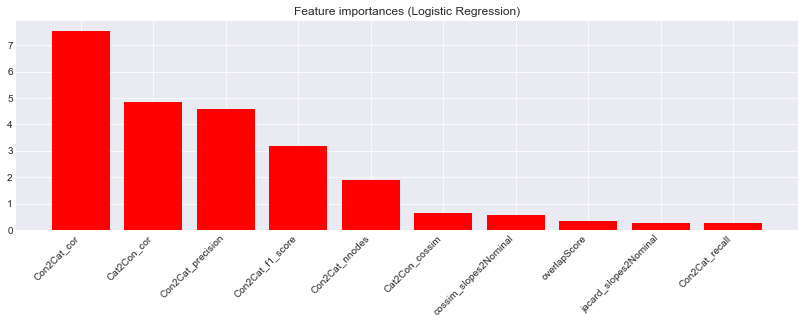

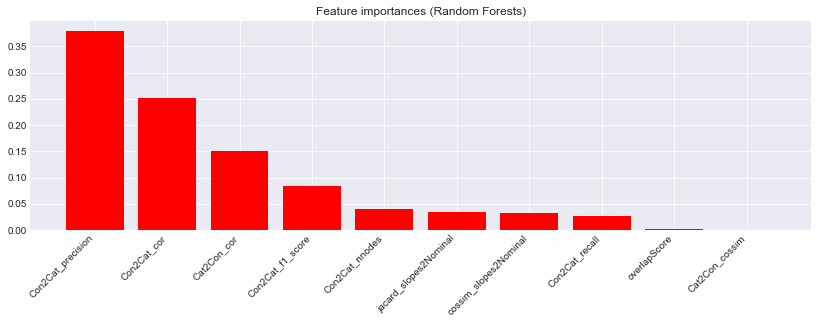

In [1188]:
pdf2 = pdf11.drop('y yhat err nominal continuous Cat2Con_nnodes Con2Cat_nnodes'.split(),axis=1)
pdf2 = pdf11.drop('y yhat err nominal continuous'.split(),axis=1)

X_train, X_test, y_train, y_test = train_test_split( pdf2, pdf11['y'], test_size=0.30, random_state=101)

print ("Logistic Regression ....\n=========================")
lr = LogisticRegressionCV(max_iter=3000)
lr.fit(X_train,y_train)
yh1 = lr.predict(X_train)
yh2 = lr.predict(X_test)
print(classification_report(y_train,yh1))
print(classification_report(y_test ,yh2))
coefs = np.abs(lr.coef_[0])
indices = np.argsort(coefs)[::-1]
plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],color="r", align="center")
plt.xticks(range(10), pdf2.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

from sklearn.ensemble import RandomForestClassifier

print ("Random Forest ....\n=========================")
clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=800, max_depth=6, max_features=6) #has already been tuned
clf.fit(X_train,y_train)
yh1 = clf.predict(X_train)
yh2 = clf.predict(X_test)
print(classification_report(y_train,yh1))
print(classification_report(y_test ,yh2))
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(10), coefs[indices[:10]], color="r", align="center")
plt.xticks(range(10), pdf2.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion();

In [1189]:
fclf = clf

pairfiletrn1 =f"{dirn}/small_tsbs-pairs-train.xlsx"
pdf1= pd.read_excel(pairfiletrn1)
pdf2 = pdf1.drop('y yhat err nominal continuous Cat2Con_nnodes Con2Cat_nnodes'.split(), errors='ignore', axis=1)
pdf2 = pdf1.drop('y yhat err nominal continuous'.split(), errors='ignore', axis=1)
yhc1  = fclf.predict(pdf2)
yhc1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1190]:
fclf = lr

pairfiletrn1 =f"{dirn}/small_tsbs-pairs-train.xlsx"
pdf1= pd.read_excel(pairfiletrn1)
pdf2 = pdf1.drop('y yhat err nominal continuous Cat2Con_nnodes Con2Cat_nnodes'.split(), errors='ignore', axis=1)
pdf2 = pdf1.drop('y yhat err nominal continuous'.split(), errors='ignore', axis=1)
yhc2  = fclf.predict(pdf2)
yhc2


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [1191]:
yhc = [yhc1[i] & yhc2[i] for i in range(len(yhc1))]
yhc = np.array(yhc)

In [1192]:
npdf = pdf1 #['nominal continuous'.split()]
npdf['yhat'] = yhc
npdf['err'] = [yhc[i] != pdf1.y[i] for i in range(len(yhc))]
npdf.to_csv(f"{dirn}/small_tsbs-pairs-predicted.csv", index=False)
npdf

,nominal,continuous,y,yhat,err,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision
0,AJ13PVHT_ON__TML,AJ13VLV1_TMP__TML,1,1,False,3,0.422574,0.000000,1,0.043451,0.521726,0.000000,13,0.486568,0.000000,0,0.697254,0.609348,0.814799
1,AJ13PVHT_ON__TML,AJ13VLV2_TMP__TML,1,1,False,3,0.491059,0.000000,1,0.345420,0.672710,1.698000,13,0.763868,0.000000,0,0.883589,0.897608,0.870000
2,AJ14PVHT_ON__TML,AJ14VLV1_TMP__TML,1,1,False,3,0.457850,0.000000,1,0.244036,0.622018,1.713700,13,0.655566,0.000000,0,0.812620,0.759201,0.874125
3,AJ14PVHT_ON__TML,AJ14VLV2_TMP__TML,1,1,False,3,0.422805,0.000000,1,0.131452,0.565726,0.000000,13,0.529790,0.000000,0,0.720579,0.628821,0.843691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,LAEPVHT_ON__TML,AJ15VLV2_TMP__TML,0,0,False,3,0.062384,0.000000,1,-0.039435,0.480283,0.000000,15,0.215409,0.000000,0,0.554399,0.491565,0.635649
77,LAEPVHT_ON__TML,AJ16VLV1_TMP__TML,0,0,False,3,0.126976,0.000000,1,-0.081225,0.459388,0.000000,13,0.215016,0.000000,0,0.390599,0.267097,0.726540
78,LAEPVHT_ON__TML,ESA1HTR_TMP__TML,0,0,False,3,0.608903,0.000000,1,0.633766,0.816883,0.000000,15,0.707136,0.000000,0,0.856847,0.879407,0.835415
79,LAEPVHT_ON__TML,ESA2HTR_TMP__TML,0,0,False,3,0.603880,0.000000,1,0.618722,0.809361,0.000000,15,0.705722,0.000000,0,0.856202,0.879103,0.834463


In [1193]:
npdf[npdf['err']]

,nominal,continuous,y,yhat,err,Cat2Con_nnodes,Cat2Con_cor,Cat2Con_corp,Cat2Con_cossim,cossim_slopes2Nominal,jacard_slopes2Nominal,overlapScore,Con2Cat_nnodes,Con2Cat_cor,Con2Cat_corp,Con2Cat_cossim,Con2Cat_f1_score,Con2Cat_recall,Con2Cat_precision
